In [2]:
#imports for PCA, ElasticNet, DecisionTree, GradientBoosting for regression
import time 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
# gaussian svr
from sklearn.svm import SVR
#LOO cross validation
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from scipy import stats
from scipy.stats import sem
import random
from xgboost import XGBRegressor
from xgboost import plot_importance

In [3]:
main_path= "D:/Year 4/HONS/Auto_QA_gestures/"
jerks_path = main_path + "Dataset/Human_likeness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path =main_path +  "Dataset/Human_likeness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path =main_path +  "Dataset/Human_likeness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"
elbow_path = main_path + "Dataset/Human_likeness_Features/elbow_angle.csv"
XX_elbow = pd.read_csv(elbow_path) # With Name of "Cond/StudySeq"

elbow_props_path = main_path + "Dataset/Human_likeness_Features/elbow_angle_props.csv"
XX_elbow_props = pd.read_csv(elbow_props_path) # With Name of "Cond/StudySeq"

hand_path = main_path + "Dataset/Human_likeness_Features/speed_of_hand_perpendicular_to_spine.csv"
XX_hand = pd.read_csv(hand_path) # With Name of "Cond/StudySeq"

hand_to_each_other_path = main_path + "Dataset/Human_likeness_Features/velocity_of_hands_moving_towards_each_other.csv"
XX_hand_to_each_other = pd.read_csv(hand_to_each_other_path) # With Name of "Cond/StudySeq"

labels_path = main_path + "Dataset/Human_likeness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"
print(YY.columns)
print(XX_elbow_props.columns)

Index(['Unnamed: 0', 'Mean_Human_Likeness_Score'], dtype='object')
Index(['Unnamed: 0', 'Left_Elbow_Angle_mean', 'Left_Elbow_Angle_max',
       'Left_Elbow_Angle_min', 'Right_Elbow_Angle_mean',
       'Right_Elbow_Angle_max', 'Right_Elbow_Angle_min'],
      dtype='object')


In [4]:
# Merging the features
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
# XY = XY.join(XX_elbow, rsuffix='_elbow')
# XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_elbow'})
XY = XY.join(XX_hand, rsuffix='_hand')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_hand'})
XY = XY.join(XX_hand_to_each_other, rsuffix='_hand_to_each_other')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_hand_to_each_other'})
XY = XY.join(XX_elbow_props, rsuffix='_elbow_props')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_elbow_props'})


# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['Unnamed: 0_YY', 'Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
          'Unnamed: 0_hand_to_each_other', 'Unnamed: 0_hand','Unnamed: 0_elbow_props'], axis=1,inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)
#drop the first column
XY.drop(XY.columns[0], axis=1, inplace=True)
XX = XY.drop(['Mean_Human_Likeness_Score'], axis=1, inplace=False)

print(XX.shape)
print(XY.shape)


(320, 128)
(320, 129)


In [5]:
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Human_Likeness_Score']
#do log scaling of all features
# XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)
print(XX.head())

(320, 122)
(320,)
   Spine1_jerks  Spine2_jerks  Spine3_jerks  LeftShoulder_jerks  \
0    108.400499    223.878591    357.320178          489.941864   
1    120.833583    242.548327    377.648025          519.982075   
2    103.729813    215.526806    346.776541          470.024284   
3     93.957801    191.742353    303.057360          427.134719   
4     77.030254    152.658334    242.297848          342.249079   

   LeftArm_jerks  LeftForearm_jerks  LeftHand_jerks  RightShoulder_jerks  \
0     776.353295        1688.907916     4788.893939           489.923543   
1     823.166945        1763.760114     5854.063832           519.961561   
2     761.203406        1714.277121     4124.820452           470.019174   
3     657.515496        2106.431322     5799.919557           427.148500   
4     594.927966        2375.106081     4875.731202           342.245544   

   RightArm_jerks  RightForearm_jerks  ...  Neck1_vs_Head  \
0      648.128187         2077.839641  ...        7.08031   


In [6]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2, random_state=42)

In [7]:
def learning_curve(model_name, model, XX, YY, param_grid, xticks, log_bool):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        
        inner_val_scores = []
        inner_train_scores = []
        for train_set_size in param_grid:
            val_scores = []
            train_scores = []
            inner_loop_cv = KFold(n_splits = n_splits, shuffle = True)
            inner_folds = inner_loop_cv.split(XX_train)
            for inner_train, val in inner_folds: # cross validation for the given train set size with the given train set
                train_indexes = random.sample(inner_train.tolist(), int(train_set_size))
                XX_train_reduced = XX_train.iloc[train_indexes]
                YY_train_reduced = YY_train.iloc[train_indexes]
                XX_val = XX_train.iloc[val]
                YY_val = YY_train.iloc[val]
                
                YY_train_reduced = YY_train_reduced.values.flatten()
                YY_val = YY_val.values.flatten()
                
                model.fit(XX_train_reduced, YY_train_reduced)
                val_scores = val_scores + [mean_squared_error(YY_val, np.clip(model.predict(XX_val), 0, 100), squared=True)]
                train_scores = train_scores + [mean_squared_error(YY_train_reduced, 
                                                                  np.clip(model.predict(XX_train_reduced), 0, 100),
                                                                  squared=True)]
            inner_val_scores = inner_val_scores + [np.mean(val_scores)]
            inner_train_scores = inner_train_scores + [np.mean(train_scores)]
        outer_val_mse = outer_val_mse + [inner_val_scores]
        outer_train_mse = outer_train_mse + [inner_train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)

    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    if (log_bool == False):
        plt.xticks(xticks)
    if (log_bool == True):
        plt.xscale('log')
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Number of Observations in the Training Set')
    plt.title(model_name + ' performance\n on different Training Set sizes')
    plt.legend()
    
    print('Best Training Set Size: ', int(param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]]))

In [8]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [9]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

In [10]:
param_grid = {'max_depth': np.arange(3, 10)}

# Instantiate a Decision Tree regressor: tree
tree = DecisionTreeRegressor( random_state=42)

tree_cv = GridSearchCV(tree, param_grid, cv=5)

# Fit it to the data
tree_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = tree_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned Decision Tree MSE: {}".format(mse))
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))


Tuned Decision Tree MSE: 90.77489923687267
Tuned Decision Tree Parameters: {'max_depth': 3}


In [11]:
#create a elastic net regressor
elastic_net = ElasticNet(random_state=42)

#set up the hyperparameter grid
param_grid = {'alpha': np.logspace(-5, 2, 8),
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

# Instantiate the GridSearchCV object: gm_cv
elastic_net_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the data
elastic_net_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = elastic_net_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned ElasticNet MSE: {}".format(mse))
print("Tuned ElasticNet Parameters: {}".format(elastic_net_cv.best_params_))


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e+03, tolerance: 1.935e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.698e+03, tolerance: 2.039e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Tuned ElasticNet MSE: 78.51585529545403
Tuned ElasticNet Parameters: {'alpha': 0.1, 'l1_ratio': 0.3}


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.902e+00, tolerance: 2.164e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.885e+03, tolerance: 2.586e+00
  model = cd_fast.enet_coordinate_descent(


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  245.42469096183777


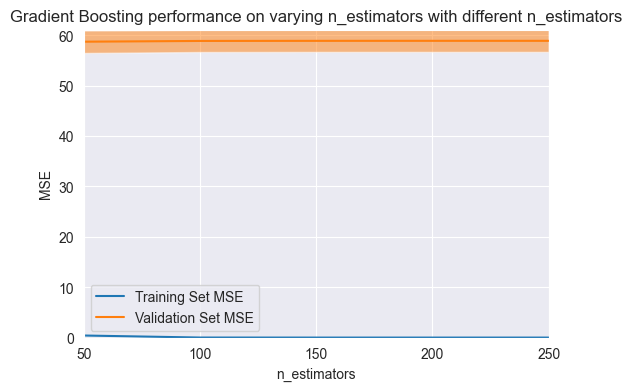

In [74]:
start = time.time()
# Instantiate a GradientBoosting regressor: gbr
gbr = GradientBoostingRegressor(random_state=42, max_depth=5)
param_grid = {'n_estimators': np.arange(50, 300, 50)}
validation_curve("Gradient Boosting", gbr, XX_train, YY_train, param_grid, False, " with different n_estimators", np.arange(50, 300, 50))
end = time.time()
print("Time taken: ", end - start)

In [77]:
#create gradient boosting regressor
gbr = GradientBoostingRegressor(random_state=42, max_depth=3, n_estimators=200)

#set up the hyperparameter grid
param_grid = {'n_estimators': np.arange(50, 300, 50)}

# Instantiate the GridSearchCV object: gbr_cv
gbr_cv = GridSearchCV(gbr, param_grid, cv=5)

# Fit it to the data
gbr_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = gbr_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned Gradient Boosting MSE: {}".format(mse))
print("Tuned Gradient Boosting Parameters: {}".format(gbr_cv.best_params_))


Tuned Gradient Boosting MSE: 73.25204395891001
Tuned Gradient Boosting Parameters: {'n_estimators': 50}


In [43]:
#create param grid for xgboost
param_grid = {'n_estimators': np.arange(50, 300, 50)}

# Instantiate a xgboost regressor: xgb
xgb = XGBRegressor(random_state=42, max_depth=3)

# Instantiate the GridSearchCV object: xgb_cv
xgb_cv = GridSearchCV(xgb, param_grid, cv=5)

# Fit it to the data
xgb_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = xgb_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned XGBoost MSE: {}".format(mse))
print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))

Tuned XGBoost MSE: 72.80490553594848
Tuned XGBoost Parameters: {'n_estimators': 50}


Tuned XGBoost MSE: 69.50492525746625


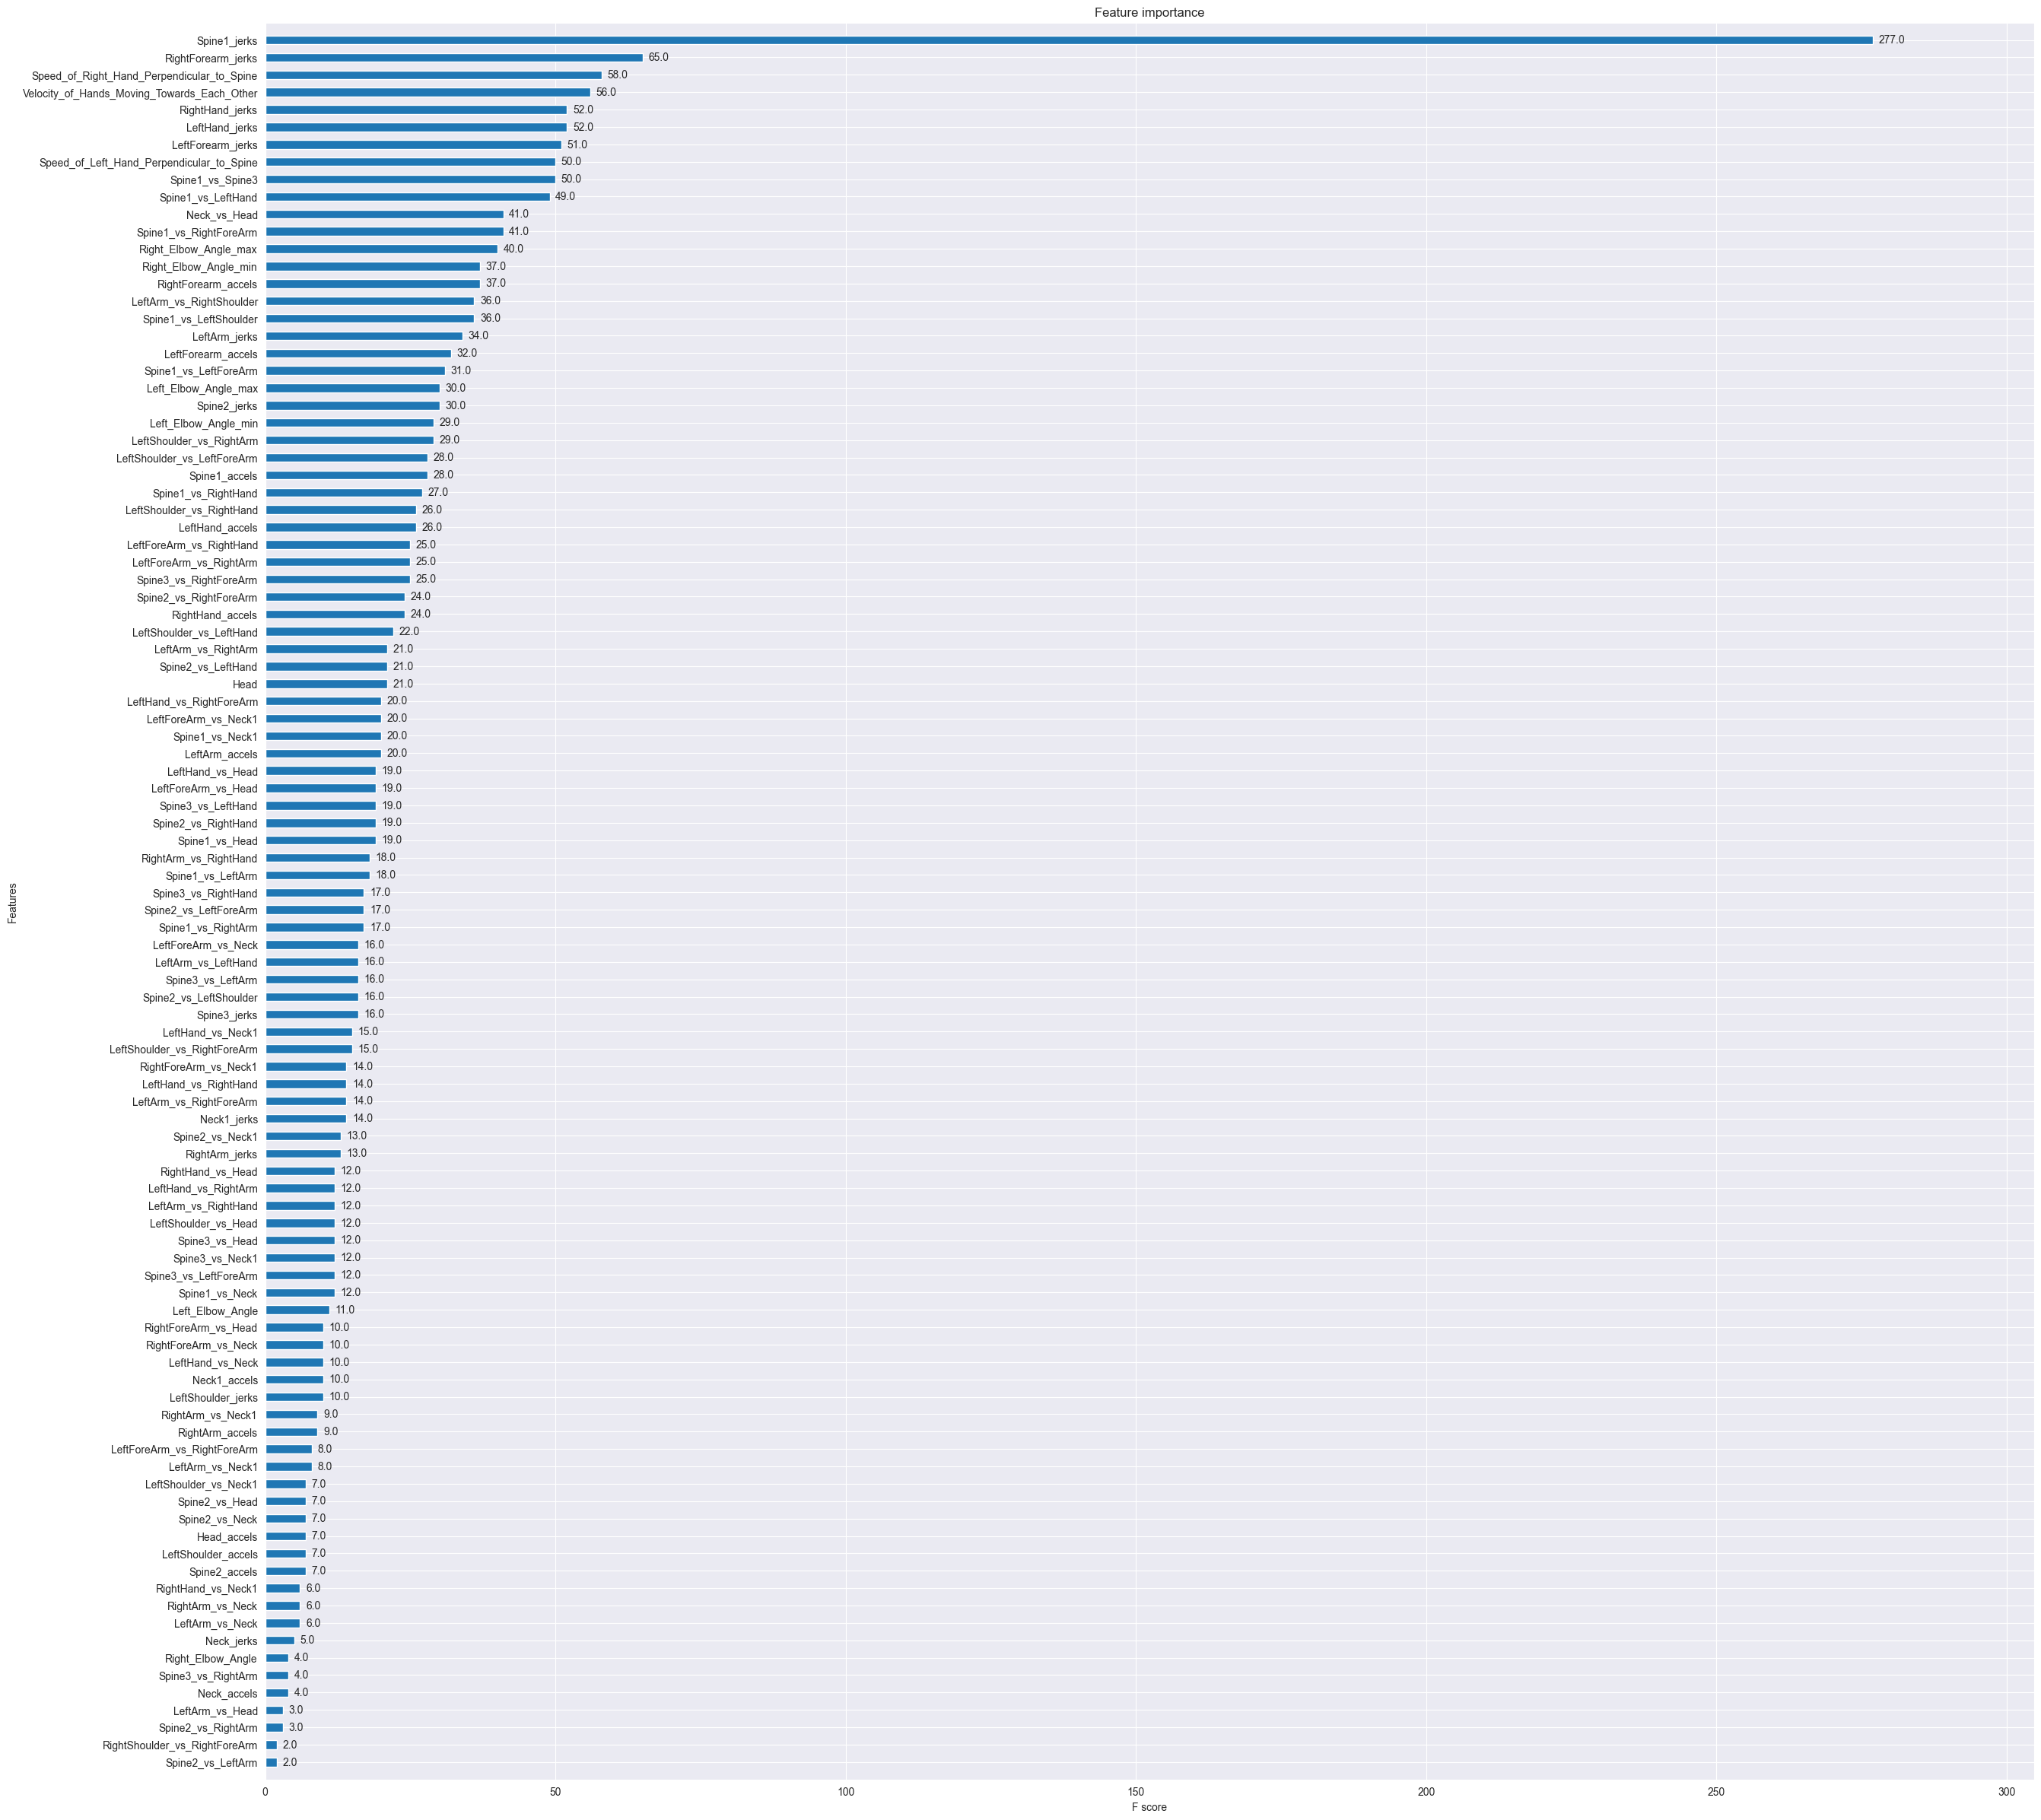

In [69]:
#create param grid for xgboost
param_grid = {'n_estimators': np.arange(50, 300, 50)}

# Instantiate a xgboost regressor: xgb
xgb_cv = XGBRegressor(random_state=42, max_depth=6)

# Instantiate the GridSearchCV object: xgb_cv
# xgb_cv = GridSearchCV(xgb, param_grid, cv=5)

# Fit it to the data
xgb_cv.fit(XX_train, YY_train)

# Predict on the test set and compute metrics
y_pred = xgb_cv.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Tuned XGBoost MSE: {}".format(mse))
# print("Tuned XGBoost Parameters: {}".format(xgb_cv.best_params_))

plot_importance(xgb_cv, height=0.5)
#increase the size of the plot
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

In [81]:
#create a stacking regressor with kernel ridge, elastic net and gradient boosting
estimators = [('elastic_net', elastic_net_cv), ('gbr', gbr_cv), ('xgb', xgb_cv)]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=xgb_cv, cv=5, passthrough=True)

#fit the stacking regressor to the training data
stacking_regressor.fit(XX_train, YY_train)

#predict on the test set and compute metrics
y_pred = stacking_regressor.predict(XX_test)
mse = mean_squared_error(YY_test, y_pred)
print("Stacking Regressor MSE: {}".format(mse))


C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.392e+03, tolerance: 1.935e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.699e+03, tolerance: 2.039e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\goyal\anaconda3\envs\mlp\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Stacking Regressor MSE: 87.59222872064143
